In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import pylab as plt
from scipy.sparse import csr_matrix
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport models.nmf
from models.nmf import nmf

## Data Analysis

In [3]:
# load data
df = pd.read_csv('songsDataset.csv')
df.columns = ['userID', 'songID', 'rating']
df.head()

,userID,songID,rating
0,0,7171,5
1,0,8637,4
2,0,21966,4
3,0,35821,5
4,0,82446,5


In [10]:
# basic data analysis: number of users and songs
n_users, n_songs = len(set(df["userID"].tolist())), len(set(df["songID"].tolist()))
all_ratings = set(df["rating"].tolist())
n_rating_levels = len(all_ratings)
print(f'Number of unique users: {n_users}')
print(f'Number of unique songs: {n_songs}')
print(f'All ratings = {all_ratings}')  # no invalid ratings

Number of unique users: 200000
Number of unique songs: 127771
All ratings = {1, 2, 3, 4, 5}


In [5]:
# check duplicates / invalid samples (same user, same, song, different ratings)
print(f'Dataset before deduplication: {len(df)} rows')
df = df.drop_duplicates(subset=['userID', 'songID']).reset_index(drop=True)
print(f'Dataset after deduplication: {len(df)} rows')  # no 

Dataset before deduplication: 2000000 rows
Dataset after deduplication: 2000000 rows


In [6]:
# Number of songs a user typically rates
user_rating_counts = df.groupby('userID')['songID'].count().reset_index()
user_rating_counts.columns = ['userID', 'song_count']
print(f'A user can give ratings to {set(user_rating_counts["song_count"])} songs')

# Number of users a song is typically rated by
song_rating_counts = df.groupby('songID')['userID'].count().reset_index()
song_rating_counts.columns = ['songID', 'user_count']
print(f'A song can be rated by {set(song_rating_counts["user_count"])} users')

A user can give ratings to {10} songs
A song can be rated by {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 2

In [7]:
# generate consecutive indices for users and songs
all_song_idx, all_user_idx = sorted(list(set(df.songID.values))), sorted(list(set(df.userID.values)))
print(len(all_song_idx), len(all_user_idx))
song_idx_dict = {song_id: i for i, song_id in enumerate(all_song_idx)}
user_idx_dict = {user_id: i for i, user_id in enumerate(all_user_idx)}
df['userID'] = df['userID'].apply(lambda x: user_idx_dict[x])
df['songID'] = df['songID'].apply(lambda x: song_idx_dict[x])

127771 200000


In [27]:
def generate_rating_matrix(df, total_df):
    # create rating matrix of shape (number of users, number of songs)
    ratings = csr_matrix(
        (df.rating.values, (df.userID.values, df.songID.values)), 
        shape=(len(total_df.userID.unique()), len(total_df.songID.unique()))
    ).toarray()
    return ratings

train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)
ratings_train, ratings_val, ratings_test = generate_rating_matrix(train, df), \
    generate_rating_matrix(val, df), generate_rating_matrix(test, df)
print(ratings_train.shape, ratings_val.shape, ratings_test.shape)

(200000, 127771) (200000, 127771) (200000, 127771)


## Matrix Fatorization

In [45]:
n_factors = 8
n_epochs = 1000
learning_rate = 0.01
lambda_reg = 0.001
n_batches = 1000
batch_size = 128
print(n_users, n_songs, n_factors, n_rating_levels)
model = nmf(n_users, n_songs, n_factors)
train_losses, val_losses = model.train(ratings_train, ratings_val, n_epochs, learning_rate, lambda_reg, n_batches, batch_size)

200000 127771 8 5
Epoch 0 | training loss = 0.1009 | validation loss = 0.1286
Epoch 10 | training loss = 0.1052 | validation loss = 0.1125
Epoch 20 | training loss = 0.1481 | validation loss = 0.1144
Epoch 30 | training loss = 0.1201 | validation loss = 0.1086
Epoch 40 | training loss = 0.0950 | validation loss = 0.1093
Epoch 50 | training loss = 0.0957 | validation loss = 0.1217
Epoch 60 | training loss = 0.1077 | validation loss = 0.1067
Epoch 70 | training loss = 0.1089 | validation loss = 0.1233
Epoch 80 | training loss = 0.1728 | validation loss = 0.1019
Epoch 90 | training loss = 0.1313 | validation loss = 0.1108
Epoch 100 | training loss = 0.1125 | validation loss = 0.1368
Epoch 110 | training loss = 0.0974 | validation loss = 0.1322
Epoch 120 | training loss = 0.0941 | validation loss = 0.1260
Epoch 130 | training loss = 0.0968 | validation loss = 0.1074
Epoch 140 | training loss = 0.0937 | validation loss = 0.1292
Epoch 150 | training loss = 0.0886 | validation loss = 0.1153
E

In [42]:
train.shape

(1280000, 3)

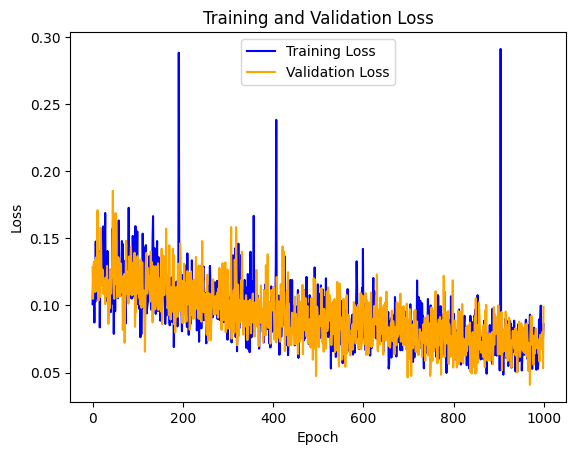

In [46]:
# Plot training loss in blue
plt.plot(train_losses, color='blue', label='Training Loss')
plt.plot(val_losses, color='orange', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()